In [1]:
import re
import random
from itertools import islice
import gc

import torch
import torch.nn.functional as F
import numpy as np
import datasets
import gensim.downloader as api

In [2]:
def set_seed(seed: int):
    # Set seed for Python's random module
    random.seed(seed)
    
    # Set seed for NumPy
    np.random.seed(seed)
    
    # Set seed for PyTorch
    torch.manual_seed(seed)
    
    # Set seed for CUDA (if using)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
        
    # Make PyTorch deterministic (this can slow down the computation)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Example of usage
set_seed(42)


# Loading Word2Vec model

In [3]:
print(api.info()['models'].keys())

word2vec_model = api.load('word2vec-google-news-300')

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])


A trained Word2Vec model is just a large collection of multi-dimensional vectors:

1. All known words are saved in the vocabulary.
1. There is one vector per each word in the vocabulary.
1. Vectors must have many dimensions to represent all meaning of a word and relation to other words.

In [4]:
print("Vocabulary size:")
len(word2vec_model.key_to_index)

Vocabulary size:


3000000

In [5]:
print("The model learns a 300-dimensional vector for each word:")
word2vec_model.vectors.shape

The model learns a 300-dimensional vector for each word:


(3000000, 300)

# Using Word2Vec Embeddings

In [6]:
dict(islice(word2vec_model.key_to_index.items(), 10))

{'</s>': 0,
 'in': 1,
 'for': 2,
 'that': 3,
 'is': 4,
 'on': 5,
 '##': 6,
 'The': 7,
 'with': 8,
 'said': 9}

In [7]:
word2vec_model['king'].shape

(300,)

To use Word2Vec model we need an efficient way of finding the representation vector for any given word.

[torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) selects a row of the matrix at a given index, very much like indexing in python lists.

There is also a fun way of selecting matrix rows using one-hot encoded vectors:
1. We need to retrieve a representation for the word "in".
1. From above we see that the index for "in" is 1.
1. One-hot 1 and get a 3,000,000-dimensional zero vector with 1 at position 1: [0, 1, 0, 0, ...]
1. Now we can use a one-hot encoded vector multiplication with the matrix to retrieve the corresponding row:

```
[0, 1, 0, 0, ...] @ [
    [a11, a12, ..., a1n],
    [a21, a22, ..., a2n],
    [a31, a32, ..., a3n],
    ...
    [am1, am2, ..., amn]
]
=
[a21, a22, ..., a2n]
```
where n = 1,...300 and m=1,...3,000,000

Note: if we combine many one-hot encoded vectors as rows then we can fetch representations of many words at once!
Note: this is super inefficient since a matrix of one-hot encoded vectors is very sparse.

In [8]:
embeddings = torch.nn.Embedding.from_pretrained(torch.tensor(word2vec_model.vectors))

In [9]:
test_one_hot_vec = F.one_hot(
    torch.tensor([word2vec_model.key_to_index["king"]]), num_classes=len(word2vec_model.key_to_index)
)[0]
print("One-hot encoded vector shape:", test_one_hot_vec.shape)
print("One-hot encoder vector sums to:", test_one_hot_vec.sum())
print("Embeddings matrix shape:", embeddings.weight.shape)
test_vec = test_one_hot_vec.type(torch.float32) @ embeddings.weight
print("Shape of the matrix multiply between the one-hot encoded vector and embeddings:", test_vec.shape)
assert torch.allclose(test_vec, torch.tensor(word2vec_model["king"]))

One-hot encoded vector shape: torch.Size([3000000])
One-hot encoder vector sums to: tensor(1)
Embeddings matrix shape: torch.Size([3000000, 300])
Shape of the matrix multiply between the one-hot encoded vector and embeddings: torch.Size([300])


In [10]:
test_vec2 = embeddings(torch.tensor([word2vec_model.key_to_index["king"]]))
assert torch.allclose(test_vec2, torch.tensor(word2vec_model["king"]))
assert torch.allclose(test_vec, test_vec2)

In [11]:
test_one_hot_batch = F.one_hot(
    torch.tensor([word2vec_model.key_to_index["student"], word2vec_model.key_to_index["university"]]),
    num_classes=len(word2vec_model.key_to_index),
)
print(f"One-hot encoded batch shape:", test_one_hot_batch.shape)
print(f"One-hot encoded batch sums to along rows:", test_one_hot_batch.sum(axis=-1))
print("Embeddings matrix shape:", embeddings.weight.shape)
test_batch = test_one_hot_batch.type(torch.float32) @ embeddings.weight
print("Shape of the matrix multiply between the one-hot encoded batch and embeddings:", test_batch.shape)
assert torch.allclose(test_batch[0], torch.tensor(word2vec_model["student"]))
assert torch.allclose(test_batch[1], torch.tensor(word2vec_model["university"]))

One-hot encoded batch shape: torch.Size([2, 3000000])
One-hot encoded batch sums to along rows: tensor([1, 1])
Embeddings matrix shape: torch.Size([3000000, 300])
Shape of the matrix multiply between the one-hot encoded batch and embeddings: torch.Size([2, 300])


In [12]:
test_batch2 = embeddings(
    torch.tensor([word2vec_model.key_to_index["student"], word2vec_model.key_to_index["university"]])
)
assert torch.allclose(test_batch2[0], torch.tensor(word2vec_model["student"]))
assert torch.allclose(test_batch2[1], torch.tensor(word2vec_model["university"]))
assert torch.allclose(test_batch, test_batch2)

In [13]:
del embeddings
gc.collect()

0

# Loading the CoNLL-2003 dataset

In [14]:
dataset = datasets.load_dataset("conll2003")
label_names = dataset["train"].features["ner_tags"].feature.names
# ner_tags = {"O": 0, "B-PER": 1, "I-PER": 2, "B-ORG": 3, "I-ORG": 4, "B-LOC": 5, "I-LOC": 6, "B-MISC": 7, "I-MISC": 8}
# assert {x: i for i, x in enumerate(label_names)} == ner_tags
dataset["train"][0]

/home/olokshyn/anaconda3/envs/nlp/lib/python3.11/site-packages/datasets/load.py:1486: FutureWarning: The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [15]:
examples = dataset["train"][:3]
examples

{'id': ['0', '1', '2'],
 'tokens': [['EU',
   'rejects',
   'German',
   'call',
   'to',
   'boycott',
   'British',
   'lamb',
   '.'],
  ['Peter', 'Blackburn'],
  ['BRUSSELS', '1996-08-22']],
 'pos_tags': [[22, 42, 16, 21, 35, 37, 16, 21, 7], [22, 22], [22, 11]],
 'chunk_tags': [[11, 21, 11, 12, 21, 22, 11, 12, 0], [11, 12], [11, 12]],
 'ner_tags': [[3, 0, 7, 0, 0, 0, 7, 0, 0], [1, 2], [5, 0]]}

In [16]:
try:
    # When a word is not in the vocabulary, it throws KeyError
    word2vec_model.key_to_index['yappie']
except KeyError as e:
    print(f"KeyError: {e}")

KeyError: 'yappie'


In [17]:
# We should use .get() instead of [key] to handle missing keys
word2vec_model.key_to_index.get('yappie', 0)

0

In [18]:
try:
    # Some very frequent words are removed from the vocabulary
    word2vec_model.key_to_index['to']
except KeyError as e:
    print(f"KeyError: {e}")

KeyError: 'to'


In [19]:
def tokenize(
    tokens: list[str],
    labels: list[str] | None = None,
    *,
    pad_to_length: int | None = None,
    truncate: int | None = None,
) -> list[int]:
    ids = [word2vec_model.key_to_index.get(token, 0) for token in tokens]
    if truncate:
        ids = ids[:truncate]
        if labels:
            labels = labels[:truncate]
    attention_mask = [1] * len(ids)
    if pad_to_length and len(ids) < pad_to_length:
        target_len = min(pad_to_length, truncate or pad_to_length)
        num_to_pad = target_len - len(ids)
        ids = ids + [0] * num_to_pad
        attention_mask = attention_mask + [0] * num_to_pad
        if labels:
            labels = labels + [0] * num_to_pad
    return {"input_ids": ids, "attention_mask": attention_mask, "labels": labels}

print([len(tokens) for tokens in examples["tokens"]])

[tokenize(x, labels, pad_to_length=10, truncate=20) for x, labels in zip(examples["tokens"], examples["ner_tags"])]

[9, 2, 2]


[{'input_ids': [1611, 11500, 1760, 315, 0, 8059, 882, 18927, 0, 0],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
  'labels': [3, 0, 7, 0, 0, 0, 7, 0, 0, 0]},
 {'input_ids': [1918, 9039, 0, 0, 0, 0, 0, 0, 0, 0],
  'attention_mask': [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
  'labels': [1, 2, 0, 0, 0, 0, 0, 0, 0, 0]},
 {'input_ids': [24412, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'attention_mask': [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
  'labels': [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]}]

In [20]:
test_batch_size = 20
test_data_subset = list(islice(iter(dataset["train"]), test_batch_size))
test_data_subset[:2]

[{'id': '0',
  'tokens': ['EU',
   'rejects',
   'German',
   'call',
   'to',
   'boycott',
   'British',
   'lamb',
   '.'],
  'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
  'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
  'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]},
 {'id': '1',
  'tokens': ['Peter', 'Blackburn'],
  'pos_tags': [22, 22],
  'chunk_tags': [11, 12],
  'ner_tags': [1, 2]}]

In [21]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

print(f"Using device: {device}")

Using device: cuda


In [22]:
def collate_fn(examples: list[dict]):
    max_size = max(len(x["tokens"]) for x in examples)
    tokenized = [tokenize(x["tokens"], x["ner_tags"], pad_to_length=max_size) for x in examples]
    input_ids = torch.tensor([x["input_ids"] for x in tokenized], device=device)
    attention_mask = torch.tensor([x["attention_mask"] for x in tokenized], dtype=torch.int16, device=device)
    labels = torch.tensor([x["labels"] for x in tokenized], dtype=torch.int64, device=device)
    return {"input_ids":input_ids, "labels": labels, "attention_mask": attention_mask}


test_batch = collate_fn(test_data_subset)
print("input shape:", test_batch["input_ids"].shape)
print("labels shape:", test_batch["labels"].shape)
max_size = max(len(x["tokens"]) for x in test_data_subset)
assert test_batch["input_ids"].shape == (test_batch_size, max_size)
assert test_batch["labels"].shape == (test_batch_size, max_size)
print(test_batch["input_ids"][0])
print([word2vec_model.key_to_index.get(x, 0) for x in dataset["train"][0]["tokens"]])
print(test_batch["labels"][0])
print(dataset["train"][0]["ner_tags"])
print(test_batch["attention_mask"][0])

input shape: torch.Size([20, 40])
labels shape: torch.Size([20, 40])
tensor([ 1611, 11500,  1760,   315,     0,  8059,   882, 18927,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
       device='cuda:0')
[1611, 11500, 1760, 315, 0, 8059, 882, 18927, 0]
tensor([3, 0, 7, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
[3, 0, 7, 0, 0, 0, 7, 0, 0]
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0',
       dtype=torch.int16)


In [23]:
# Reduce this if you run out of GPU memory
batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(dataset["validation"], batch_size=batch_size, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(dataset["test"], batch_size=batch_size, collate_fn=collate_fn)

for batch in islice(train_loader, 10):
    print(batch["input_ids"].shape, batch["labels"].shape)

torch.Size([32, 47]) torch.Size([32, 47])
torch.Size([32, 44]) torch.Size([32, 44])
torch.Size([32, 16]) torch.Size([32, 16])
torch.Size([32, 46]) torch.Size([32, 46])
torch.Size([32, 40]) torch.Size([32, 40])
torch.Size([32, 44]) torch.Size([32, 44])
torch.Size([32, 37]) torch.Size([32, 37])
torch.Size([32, 39]) torch.Size([32, 39])
torch.Size([32, 36]) torch.Size([32, 36])
torch.Size([32, 52]) torch.Size([32, 52])


# Model training

In [24]:
class NERClassifier(torch.nn.Module):
    def __init__(self, embed_dim: int, tags: list[str]):
        super().__init__()
        self.tags = tags
        self.embedding = torch.nn.Embedding.from_pretrained(torch.tensor(word2vec_model.vectors))
        self.linear = torch.nn.Linear(embed_dim, len(self.tags))

    def forward(self, x):
        x = self.embedding(x)
        x = self.linear(x)
        return x
    
    # See: https://pytorch.org/docs/stable/notes/autograd.html#locally-disable-grad-doc
    @torch.inference_mode
    def predict(self, input_text):
        words = re.split("\s+", re.sub(r'[\(\)\[\]\?"“]', "", input_text))
        tokens = tokenize(words)["input_ids"]
        input_ids = torch.tensor([tokens], device=self.embedding.weight.device)
        outputs = self(input_ids)
        preds = torch.argmax(outputs, dim=-1)
        labels = [self.tags[x.item()] for x in preds[0]]
        return dict(zip(words, labels))


embed_dim = word2vec_model.vectors.shape[1]
assert embed_dim == 300

model = NERClassifier(embed_dim, label_names).to(device)
criterion = torch.nn.CrossEntropyLoss()
# Adam has many hyperparameters - play with it!
# Try other optimizers as well!
optimizer = torch.optim.Adam(model.parameters())

# Train the model
# NOTE: always track the validation accuracy to see when it diverges from the training accuracy!
# This is a sign of overfitting!
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for batch in train_loader:
        input_ids = batch["input_ids"]
        labels = batch["labels"]
        attention_mask = batch["attention_mask"]
        optimizer.zero_grad()
        outputs = model(input_ids)
        outputs = outputs * attention_mask.unsqueeze(-1)
        loss = criterion(outputs.reshape(-1, len(label_names)), labels.reshape(-1))
        # loss must be a scalar for loss.backward() to work!
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0
    model.eval()
    with torch.inference_mode():
        for batch in val_loader:
            input_ids = batch["input_ids"]
            labels = batch["labels"]
            attention_mask = batch["attention_mask"]
            outputs = model(input_ids)
            outputs = outputs * attention_mask.unsqueeze(-1)
            loss = criterion(outputs.reshape(-1, len(label_names)), labels.reshape(-1))
            val_loss += loss.item()
    print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")

Epoch 1, Train Loss: 1.8103, Val Loss: 1.6384
Epoch 2, Train Loss: 1.5977, Val Loss: 1.5418
Epoch 3, Train Loss: 1.5209, Val Loss: 1.4842
Epoch 4, Train Loss: 1.4700, Val Loss: 1.4446
Epoch 5, Train Loss: 1.4346, Val Loss: 1.4175
Epoch 6, Train Loss: 1.4104, Val Loss: 1.3993
Epoch 7, Train Loss: 1.3940, Val Loss: 1.3871
Epoch 8, Train Loss: 1.3827, Val Loss: 1.3788
Epoch 9, Train Loss: 1.3749, Val Loss: 1.3731
Epoch 10, Train Loss: 1.3693, Val Loss: 1.3691
Epoch 11, Train Loss: 1.3653, Val Loss: 1.3663
Epoch 12, Train Loss: 1.3623, Val Loss: 1.3642
Epoch 13, Train Loss: 1.3600, Val Loss: 1.3627
Epoch 14, Train Loss: 1.3583, Val Loss: 1.3616
Epoch 15, Train Loss: 1.3570, Val Loss: 1.3607
Epoch 16, Train Loss: 1.3559, Val Loss: 1.3601
Epoch 17, Train Loss: 1.3550, Val Loss: 1.3596
Epoch 18, Train Loss: 1.3543, Val Loss: 1.3592
Epoch 19, Train Loss: 1.3537, Val Loss: 1.3589
Epoch 20, Train Loss: 1.3532, Val Loss: 1.3586


[torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) does `softmax` for you:

> The input is expected to contain the unnormalized logits for each class (which do not need to be positive or sum to 1, in general).

              precision    recall  f1-score   support

           O       0.98      0.99      0.99     29346
       B-PER       0.78      0.75      0.76      1780
       I-PER       0.62      0.66      0.64      1133
       B-ORG       0.65      0.70      0.68      1297
       I-ORG       0.56      0.44      0.49       664
       B-LOC       0.86      0.80      0.83      1795
       I-LOC       0.69      0.41      0.51       244
      B-MISC       0.81      0.74      0.77       864
      I-MISC       0.77      0.53      0.63       304

    accuracy                           0.93     37427
   macro avg       0.75      0.67      0.70     37427
weighted avg       0.93      0.93      0.93     37427



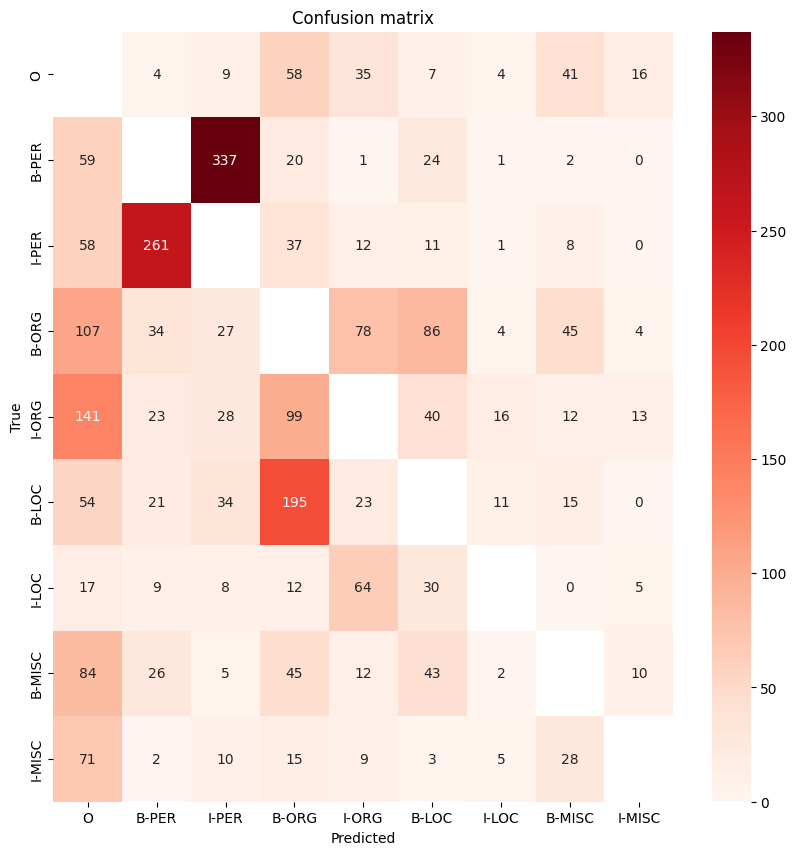

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


val_preds = []
val_labels = []
model.eval()
with torch.inference_mode():
    for batch in val_loader:
        input_ids = batch["input_ids"]
        labels = batch["labels"]
        attention_mask = batch["attention_mask"]
        outputs = model(input_ids)

        # outpus shape: (batch_size, seq_len, num_tags)
        # Contains log probabilities for each tag. We need to take the tag with the highest probability.
        # preds shape: (batch_size, seq_len)
        preds = torch.argmax(outputs, dim=-1)
        # Make sure that padding gets the 'O' tag for which index is 0.
        # This can be simplified to just preds *= attention_mask, but below words for non-zero indexes (for future).
        preds = preds * attention_mask + (1 - attention_mask) * 0

        assert preds.shape == input_ids.shape
        assert preds.shape == labels.shape
        # Remove unknown words and padding
        flat_inputs = input_ids.view(-1).cpu()
        flat_preds = preds.view(-1).cpu()
        flat_labels = labels.view(-1).cpu()
        flat_preds = [pred.item() for pred, input_id in zip(flat_preds, flat_inputs) if input_id != 0]
        flat_labels = [label.item() for label, input_id in zip(flat_labels, flat_inputs) if input_id != 0]

        val_preds.extend(flat_preds)
        val_labels.extend(flat_labels)

# Confusion Matrix and Classification Report
print(classification_report(val_labels, val_preds, target_names=label_names))
conf_mat = confusion_matrix(val_labels, val_preds)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    conf_mat,
    xticklabels=label_names,
    yticklabels=label_names,
    annot=True,
    fmt="d",
    # Use this to ignore the correct predictions along the diagonal when coloring the confusion matrix
    mask=np.eye(len(conf_mat), dtype=bool),
    cmap="Reds"
)
plt.ylabel("True")
plt.xlabel("Predicted")
plt.title("Confusion matrix")
plt.show()

# Testing

In [26]:
model.predict("""Apple collaborates with healthcare organizations worldwide, including a significant partnership with Stanford University
on the Apple Heart Study, which uses Apple Watch to detect irregular heart rhythms,
helping users catch early signs of atrial fibrillation. This collaboration is among the largest virtual cardiac studies globally.
Apple, co-founded by Steve Jobs, has teamed up with Singapore’s Health Promotion Board for the LumiHealth initiative,
a wellness program encouraging Apple Watch users in Singapore to adopt healthier lifestyle habits through personalized reminders and incentives.
""")

{'Apple': 'B-ORG',
 'collaborates': 'O',
 'with': 'O',
 'healthcare': 'O',
 'organizations': 'O',
 'worldwide,': 'O',
 'including': 'O',
 'a': 'O',
 'significant': 'O',
 'partnership': 'O',
 'Stanford': 'B-ORG',
 'University': 'O',
 'on': 'O',
 'the': 'O',
 'Heart': 'B-MISC',
 'Study,': 'O',
 'which': 'O',
 'uses': 'O',
 'Watch': 'O',
 'to': 'O',
 'detect': 'O',
 'irregular': 'O',
 'heart': 'O',
 'rhythms,': 'O',
 'helping': 'O',
 'users': 'O',
 'catch': 'O',
 'early': 'O',
 'signs': 'O',
 'of': 'O',
 'atrial': 'O',
 'fibrillation.': 'O',
 'This': 'O',
 'collaboration': 'O',
 'is': 'O',
 'among': 'O',
 'largest': 'O',
 'virtual': 'O',
 'cardiac': 'O',
 'studies': 'O',
 'globally.': 'O',
 'Apple,': 'O',
 'co-founded': 'O',
 'by': 'O',
 'Steve': 'B-PER',
 'Jobs,': 'O',
 'has': 'O',
 'teamed': 'O',
 'up': 'O',
 'Singapore’s': 'O',
 'Health': 'O',
 'Promotion': 'I-ORG',
 'Board': 'I-ORG',
 'for': 'O',
 'LumiHealth': 'O',
 'initiative,': 'O',
 'wellness': 'O',
 'program': 'O',
 'encouraging

In [27]:
model.predict("""Approximately 60 percent of Austrian territory is mountainous 
and belongs to the Eastern Alps (Tyrol Central Alps, Hohe Tauern and Niedere Tauern,
Northern Calcareous or Limestone Alps, Southern Calcareous Alps and Wienerwald). 
The Bohemian Massif is in Upper and Lower Austria, north of the Danube.""")

{'Approximately': 'O',
 '60': 'O',
 'percent': 'O',
 'of': 'O',
 'Austrian': 'B-MISC',
 'territory': 'O',
 'is': 'O',
 'mountainous': 'O',
 'and': 'O',
 'belongs': 'O',
 'to': 'O',
 'the': 'O',
 'Eastern': 'B-MISC',
 'Alps': 'I-ORG',
 'Tyrol': 'I-ORG',
 'Central': 'B-ORG',
 'Alps,': 'O',
 'Hohe': 'I-PER',
 'Tauern': 'O',
 'Niedere': 'I-PER',
 'Tauern,': 'O',
 'Northern': 'B-ORG',
 'Calcareous': 'O',
 'or': 'O',
 'Limestone': 'B-ORG',
 'Southern': 'B-ORG',
 'Wienerwald.': 'O',
 'The': 'O',
 'Bohemian': 'I-ORG',
 'Massif': 'I-ORG',
 'in': 'O',
 'Upper': 'O',
 'Lower': 'O',
 'Austria,': 'O',
 'north': 'O',
 'Danube.': 'O'}

In [28]:
model.predict("""Schwarzenegger began lifting weights at age 15 and won the Mr. Universe title aged 20, 
and subsequently the Mr. Olympia title seven times. He is tied with Phil Heath for the 
joint-second number of all-time Mr. Olympia wins, behind Ronnie Coleman and Lee Haney, 
who are joint-first with eight wins each. He is widely regarded as one of, 
if not the greatest, bodybuilders of all-time, and has written many books and articles about it""")

{'Schwarzenegger': 'B-PER',
 'began': 'O',
 'lifting': 'O',
 'weights': 'O',
 'at': 'O',
 'age': 'O',
 '15': 'O',
 'and': 'O',
 'won': 'O',
 'the': 'O',
 'Mr.': 'O',
 'Universe': 'I-LOC',
 'title': 'O',
 'aged': 'O',
 '20,': 'O',
 'subsequently': 'O',
 'Olympia': 'B-LOC',
 'seven': 'O',
 'times.': 'O',
 'He': 'O',
 'is': 'O',
 'tied': 'O',
 'with': 'O',
 'Phil': 'B-PER',
 'Heath': 'B-PER',
 'for': 'O',
 'joint-second': 'O',
 'number': 'O',
 'of': 'O',
 'all-time': 'O',
 'wins,': 'O',
 'behind': 'O',
 'Ronnie': 'B-PER',
 'Coleman': 'I-PER',
 'Lee': 'B-PER',
 'Haney,': 'O',
 'who': 'O',
 'are': 'O',
 'joint-first': 'O',
 'eight': 'O',
 'wins': 'O',
 'each.': 'O',
 'widely': 'O',
 'regarded': 'O',
 'as': 'O',
 'one': 'O',
 'of,': 'O',
 'if': 'O',
 'not': 'O',
 'greatest,': 'O',
 'bodybuilders': 'O',
 'all-time,': 'O',
 'has': 'O',
 'written': 'O',
 'many': 'O',
 'books': 'O',
 'articles': 'O',
 'about': 'O',
 'it': 'O'}